In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import laplace_asymmetric

In [2]:
#Data Simulation according to DGP
def simulate_data(T, alpha, beta, gamma, theta):
    np.random.seed(123)
    X = np.zeros(T)
    Y = np.zeros(T)
    # Generate X values from N(0, 1)
    X[0] = np.random.normal(0, 1)
    epsilon_t = np.random.randn()
    epsilon_t_lag = np.roll(epsilon_t, 1)
    # Generate Y values
    for t in range(1, T):
        epsilon_t = np.random.randn()
        epsilon_t_lag = np.roll(epsilon_t, 1)
        X[t] = np.random.normal(0, 1)
        Y[t] = alpha + beta * Y[t - 1] + gamma * X[t] + epsilon_t + theta * epsilon_t_lag
    return pd.DataFrame({'X': X, 'Y': Y})

# Set the parameters for each quantile level
quantiles = [0.1, 0.5, 0.9]
#quantiles = [0.5]
parameters = {
    0.1: {'alpha': -0.2, 'beta': 0.3, 'gamma': 0.2, 'theta': 0.9},
    0.5: {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.3, 'theta': 0.9},
    0.9: {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.4, 'theta': 0.9}}
    
T = 334

df = pd.DataFrame()
# Simulate data for each quantile level and concatenate into a single DataFrame
for quantile in quantiles:
    params = parameters[quantile]
    data = simulate_data(T, params['alpha'], params['beta'], params['gamma'], params['theta'])
    df = pd.concat([df, data], ignore_index=True)
print(df)


             X         Y
0    -1.085631  0.000000
1    -1.506295  0.036400
2     1.651437 -0.958133
3    -0.428913 -5.183913
4    -0.866740  0.476757
...        ...       ...
997   0.047002 -0.896465
998   0.747128 -2.144993
999  -0.605013 -2.435173
1000  0.577794 -0.890419
1001  1.642183  0.311066

[1002 rows x 2 columns]


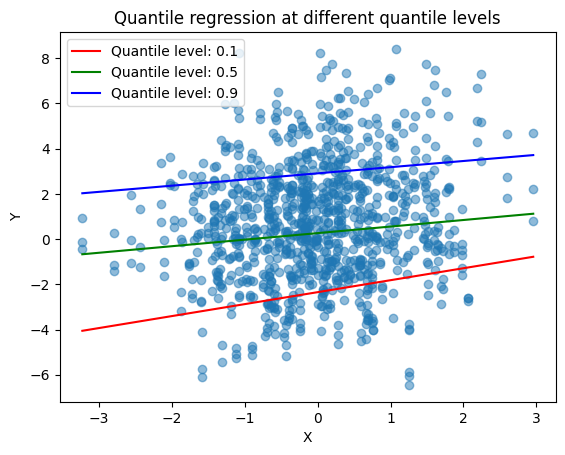

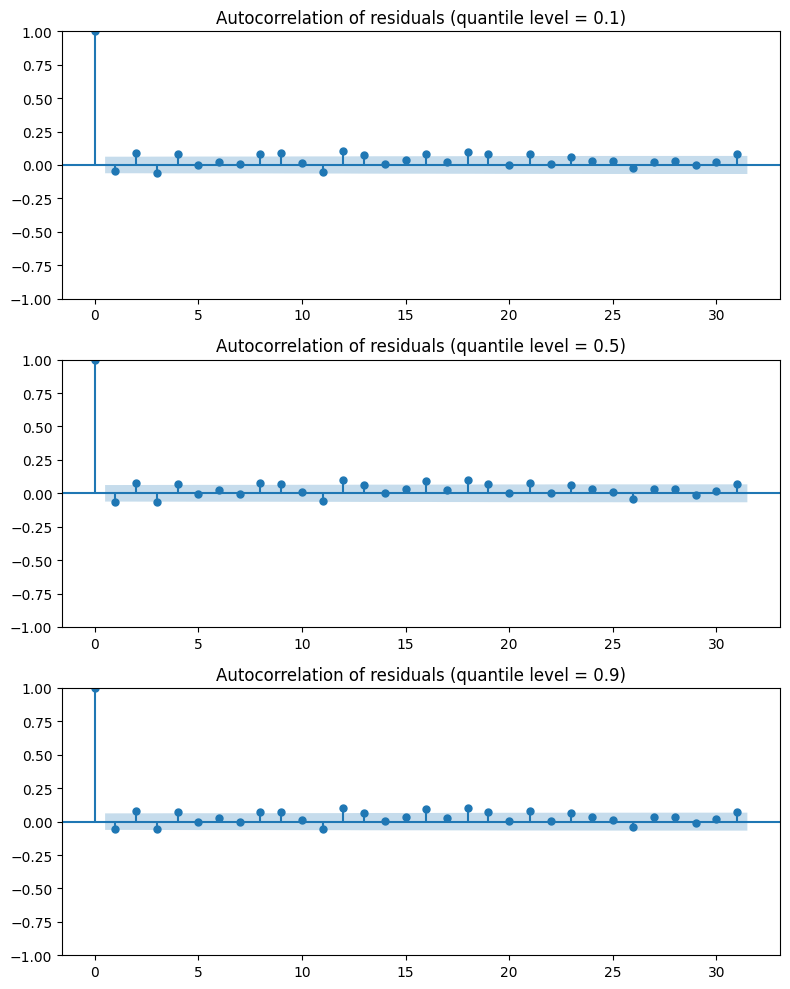

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.1911
 Model:                       QuantReg   Bandwidth:                      0.8237
 Method:                 Least Squares   Sparsity:                        12.54
 Date:                Sat, 01 Jul 2023   No. Observations:                 1002
 Time:                        19:09:12   Df Residuals:                      999
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -2.3475      0.123    -19.126      0.000      -2.588      -2.107
 x1             0.6120      0.039     15.777      0.000       0.536       0.688
 x2             0.5288      0.108      4.905      0.000       0.317   

In [3]:
################################ Quantile linear regression with package ################################
def fit_quantile(df):
    y = df['Y'].values.astype(float)
    x = df['X'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0   
    X = np.column_stack((np.ones_like(x), y_lag, x))
    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 250)

    # Plot the regression lines
    ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

fit_quantile(df)

In [5]:
#RMSE for standard linear quantile regression with package
actuals1 = np.array([-0.2, 0.3, 0.2]) #p=0.1 true parameters alpha, beta, gamma
actuals5 = np.array([0.2, 0.5, 0.3]) #p=0.5
actuals9 = np.array([0.6, 0.7, 0.4]) #p=0.9
beta_pac1 = np.array([-2.3475, 0.6120 , 0.5288])  #beta result from package for p=0.1
beta_pac5 = np.array([0.2636, 0.6317, 0.2895])  
beta_pac9 = np.array([2.9064, 0.6227, 0.2726])    
  # Calculate the biases
biases_ols = actuals1 - np.array(beta_pac1)
for i, bias in enumerate(biases_ols):
    print(f"OLS_bias_param_{i} = {bias:.4f}")
    
mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE p=0.1
rmse_ols = np.sqrt(mse_ols)
print(f"OLS_RMSE = {rmse_ols:.4f}")
    
biases_gls = actuals5 - np.array(beta_pac5) # Calculate the biases
for i, bias in enumerate(biases_gls):
    print(f"GLS_bias_param_{i} = {bias:.4f}")
    
mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE p=0.5
rmse_gls = np.sqrt(mse_gls)
print(f"GLS_RMSE = {rmse_gls:.4f}")

biases_gls = actuals9 - np.array(beta_pac9) # Calculate the biases
for i, bias in enumerate(biases_gls):
    print(f"GLS_bias_param_{i} = {bias:.4f}")
    
mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE p=0.9
rmse_gls = np.sqrt(mse_gls)
print(f"GLS_RMSE = {rmse_gls:.4f}")

OLS_bias_param_0 = 2.1475
OLS_bias_param_1 = -0.3120
OLS_bias_param_2 = -0.3288
OLS_RMSE = 1.2672
GLS_bias_param_0 = -0.0636
GLS_bias_param_1 = -0.1317
GLS_bias_param_2 = 0.0105
GLS_RMSE = 0.0847
GLS_bias_param_0 = -2.3064
GLS_bias_param_1 = 0.0773
GLS_bias_param_2 = 0.1274
GLS_RMSE = 1.3344


In [11]:
#Autocorrelation paramter estimation PACKAGE
y = df['Y'].values.astype(float)
x = df['X'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_pac1 = np.array([-2.3475, 0.6120 , 0.5288])  
beta_pac5 = np.array([0.2636, 0.6317, 0.2895])  
beta_pac9 = np.array([2.9064, 0.6227, 0.2726]) 
ε = y - X @ beta_pac1 #residuals for p=0.1
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho 1= ", theta_hat)

ε = y - X @ beta_pac5 #residuals for p=0.5
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho 5= ", theta_hat)

ε = y - X @ beta_pac9 #residuals for p=0.9
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho 9= ", theta_hat)

rho 1=  [[0.62081506]]
rho 5=  [[-0.06638663]]
rho 9=  [[0.61331985]]


In [12]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['Y'].values
    T = min(M, len(y_dataset))
    y = df['Y'].values[:T]
    x = df['X'].values[:T]  # extract data
    
    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []
    y_new = np.zeros(M+1)
    y_new[0] = y[0]

    beta = 0.5
    gamma = 0.3
    
    np.random.seed(123)
    for i in range(1, M+1):  
        epsilon = np.random.randn(T) #redraw erros
        for j in range(T):
            y_new[j] = beta * y_new[j-1] + gamma * x[j] + epsilon[j] #update y, keeping x 

        # OLS estimation of the parameters
        y_lag = np.roll(y_new, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon, 1)
        epsilon_lag[0] = 0
        y_lag = y_lag[:T]
        X = np.column_stack((np.ones_like(x)[:T], y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break
     # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
    # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")

In [29]:
M=100
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.13371850595914297]
OLS beta_hat:  [-0.01692705194229646]
OLS gamma_hat:  [0.4528071260997112]
OLS theta_hat:  [1.0]
GLS alpha_hat:  [0.12230361558303784]
GLS beta_hat:  [0.011845606047328011]
GLS gamma_hat:  [0.3809850622983705]
GLS theta_hat:  [0.9999999999999978]
OLS_bias_param_0 = 0.0663
OLS_bias_param_1 = 0.5169
OLS_bias_param_2 = -0.1528
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.2761
GLS_bias_param_0 = 0.0777
GLS_bias_param_1 = 0.4882
GLS_bias_param_2 = -0.0810
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.2554


In [ ]:
GLS alpha_hat:  [0.7836050302226402]
GLS beta_hat:  [0.7465211020199857]
GLS gamma_hat:  [0.7385542816867845]

In [30]:
M=250
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [-0.32440925483137806]
OLS beta_hat:  [-0.017250048515057667]
OLS gamma_hat:  [0.2364633428735872]
OLS theta_hat:  [0.9999999999999997]
GLS alpha_hat:  [-0.32135482921759034]
GLS beta_hat:  [0.038358538678335455]
GLS gamma_hat:  [0.20005888980258896]
GLS theta_hat:  [0.9999999999999999]
OLS_bias_param_0 = 0.5244
OLS_bias_param_1 = 0.5173
OLS_bias_param_2 = 0.0635
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.3730
GLS_bias_param_0 = 0.5214
GLS_bias_param_1 = 0.4616
GLS_bias_param_2 = 0.0999
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.3553


In [31]:
M=1000
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.7305371396653015]
OLS beta_hat:  [-0.05393575331151918]
OLS gamma_hat:  [0.34886895804943424]
OLS theta_hat:  [1.0000000000000004]
GLS alpha_hat:  [0.7836050302226402]
GLS beta_hat:  [0.7465211020199857]
GLS gamma_hat:  [0.7385542816867845]
GLS theta_hat:  [1.000000000000052]
OLS_bias_param_0 = -0.5305
OLS_bias_param_1 = 0.5539
OLS_bias_param_2 = -0.0489
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.3875
GLS_bias_param_0 = -0.5836
GLS_bias_param_1 = -0.2465
GLS_bias_param_2 = -0.4386
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.3885


In [35]:
y = df['Y'].values.astype(float)
x = df['X'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_ols1 = np.array([0.1337, -0.0169, 0.4528])  #100
beta_ols2 = np.array([-0.3244, -0.0172, 0.2364])  #250
beta_ols0 = np.array([0.7305, -0.0539, 0.3488])  #1000
ε = y - X @ beta_ols0
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(theta_hat)

[[0.65375909]]


In [ ]:
OLS alpha_hat:  [0.13371850595914297]
OLS beta_hat:  [-0.01692705194229646]
OLS gamma_hat:  [0.4528071260997112]
OLS theta_hat:  [1.0]
GLS alpha_hat:  [0.12230361558303784]
GLS beta_hat:  [0.011845606047328011]
GLS gamma_hat:  [0.3809850622983705]
GLS theta_hat:  [0.9999999999999978]

0.5
OLS alpha_hat:  [-0.32440925483137806]
OLS beta_hat:  [-0.017250048515057667]
OLS gamma_hat:  [0.2364633428735872]

OLS alpha_hat:  [0.7305371396653015]
OLS beta_hat:  [-0.05393575331151918]
OLS gamma_hat:  [0.34886895804943424

In [14]:
def Laplace_estimation(df, p, M, params0, actuals, beta, gamma):

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['Y'].values
    T = min(M, len(y_dataset))
    y = df['Y'].values[:T]
    x = df['X'].values[:T]  # extract data
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0
    y_new = np.zeros(M+1)
    y_new[0] = y[0]


    def log_l_Asym_Lap(params, X, y):
        α, β, γ = params  # Separate the parameters
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1 - p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2 * p) / p * (1 - p)
        
        # Calculate the log-likelihood
        ll -= np.sum(np.log(np.sqrt(1/z)) + 0.5 * ((y - α - β * X[:, 1] - γ * X[:, 2]) ** 2) / (τ_2 * z))
        #ll -= np.sum(np.log(z)) +  np.sum(((y - α - β * X[:, 1] - γ * X[:, 2]) ** 2)/ (τ_2 * z))
        return -ll

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        for j in range(T):
            y_new[j] = beta * y_new[j-1] + gamma * x[j] + epsilon[j]
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Powell')  # minimize the negative log-likelihood #method='Powell'
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1
        
        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix


In [15]:
#Estimation at p=0.5 and T=100
params0 = np.array([0.2, 0.5, 0.3], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
beta = 0.5
gamma = 0.3
result_matrix = Laplace_estimation(df, 0.5, 1000, params0, actuals, beta, gamma)

Beta Matrix:
[[ 0.06740664  0.45995489  1.81914937]
 [-0.41803397 -0.11185364  1.01356677]
 [-0.40683478  0.51282116  1.30467744]
 ...
 [ 0.2        -0.17376206 -0.30139995]
 [ 2.77371432 -0.00991078  0.4956035 ]
 [-0.18675272 -0.11803397 -0.31185364]]

RMSE Matrix:
[[0.88071929 0.88071929 0.88071929]
 [0.64948913 0.64948913 0.64948913]
 [0.6776896  0.6776896  0.6776896 ]
 ...
 [0.52142024 0.52142024 0.52142024]
 [1.51902108 1.51902108 1.51902108]
 [0.54951752 0.54951752 0.54951752]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[0.3102408  0.40356937 0.8480594 ]

Mean of RMSE:
0.8094468252623547
